In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from pycaret.regression import *

In [2]:
df_train=pd.read_csv('movies_train.csv', index_col='title')
df_test=pd.read_csv('movies_test.csv', index_col='title')
submission=pd.read_csv('movies_submission.csv', index_col='title')

In [3]:
print(list(df_train))

['distributor', 'genre', 'release_time', 'time', 'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num']


In [4]:
# title : 영화의 제목
# distributor : 배급사
# genre : 장르
# release_time : 개봉일
# time : 상영시간(분)
# screening_rat : 상영등급
# director : 감독이름
# dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
# dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
# num_staff : 스텝수
# num_actor : 주연배우수
# box_off_num : 관객수

In [5]:
exp_reg = setup(df_train, #Train Data
                target = 'box_off_num',  
                session_id = 123,
                normalize = True, # 데이터 세트 정규화
                normalize_method = 'zscore', #normalize= true 경우 기본값 zscore
                numeric_features=['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor'],
                polynomial_features = True,
                trigonometry_features = True,
                remove_outliers = True,
                outliers_threshold = 0.01,
                remove_multicollinearity = True, # 다중공선성 제거
                silent = True,    # 원격 커널에서 실행할때 true            
                ignore_low_variance = True, #낮은 분산 무시
                use_gpu = True
                )

,Description,Value
0,session_id,123
1,Target,box_off_num
2,Original Data,"(600, 11)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(414, 392)"


In [6]:
best_model = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,675226.9642,2321125835178.6772,1397184.8492,0.1964,3.8347,585.5672,0.0350
lightgbm,Light Gradient Boosting Machine,678471.2125,2223167170923.9468,1413431.8344,0.0970,3.3800,170.5905,0.0840
knn,K Neighbors Regressor,592233.6788,2412982720053.1899,1429471.8330,0.1487,2.4870,40.8325,0.1950
rf,Random Forest Regressor,573048.2139,2428559822158.9077,1448407.6154,0.1210,2.0964,34.9913,0.4970
huber,Huber Regressor,544223.0106,2584543735910.1538,1455197.3372,0.1756,2.9052,232.1735,0.0760
et,Extra Trees Regressor,546572.1522,2773409665726.6533,1510897.3823,0.0816,1.9749,13.9217,0.5570
gbr,Gradient Boosting Regressor,645523.0195,2699675702503.1245,1539858.4659,-0.0106,2.8329,121.9630,0.2200
ridge,Ridge Regression,860641.5804,2778433694062.7764,1572732.2662,-0.1254,4.0752,1316.3597,0.0260
par,Passive Aggressive Regressor,595649.8826,3105221391778.6919,1601925.4555,-0.0018,2.5276,49.5547,0.6960
br,Bayesian Ridge,947634.4616,3135119783601.3330,1624797.7275,-0.0630,4.7398,3099.1438,0.1170


In [7]:
en = create_model('en', cross_validation=False)
lightgbm = create_model('en', cross_validation=False)
rf = create_model('rf', cross_validation=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,652315.4312,2.542892e+12,1.594645e+06,0.355,2.5171,40.5974


In [8]:
# 하이퍼파라미터 튜닝
# 모델 하이퍼파라미터 튜닝(Tune)

tuned_en = tune_model(en, optimize='RMSE', n_iter=100)
tuned_lightgbm = tune_model(lightgbm, optimize='RMSE', n_iter=100)
tuned_rf = tune_model(rf, optimize='RMSE', n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,714122.9127,1618071344802.6169,1272034.3332,0.3272,4.5862,307.2735
1,459050.0780,705633417243.5892,840019.8910,-0.1078,4.2231,189.7757
2,685368.2550,1260310720693.2332,1122635.6135,0.1084,3.9544,4628.6434
3,552896.2246,949367234172.0220,974354.7784,0.3221,3.9365,171.6337
4,488654.1040,788950419416.3666,888228.8103,0.3552,4.4734,477.3039
5,1053843.1617,4709203737119.0527,2170069.9844,0.2193,4.1992,761.8339
6,444396.3199,325788784445.0162,570779.1030,0.4590,4.4467,609.3360
7,1007741.1397,7435638616242.4863,2726836.7418,0.1898,4.4564,2827.9346
8,734667.1940,3274696966366.8184,1809612.3801,0.2647,3.5491,108.0466


In [9]:
# 블렌딩
# 모델 블렌딩(Blend)

blender_specific = blend_models(estimator_list = [tuned_en,tuned_lightgbm,tuned_rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,687219.1576,1742569382775.3438,1320064.1586,0.2755,4.2022,186.5089
1,447740.6730,796254051189.3669,892330.6849,-0.2501,3.9854,138.1235
2,674014.8267,1226286307599.5056,1107378.1231,0.1325,3.3650,79.7799
3,555963.5615,989177816596.9510,994574.1886,0.2936,3.8284,160.8623
4,389305.2857,699294061230.5684,836238.0410,0.4284,4.0777,325.5255
5,1025677.6424,4962451209322.2920,2227655.9899,0.1774,3.9063,443.0303
6,407817.6802,379056895623.7966,615675.9664,0.3705,4.0027,353.6083
7,991440.8125,6806314670058.5732,2608891.4638,0.2584,4.2208,1949.0931
8,752247.0539,3526639619544.6724,1877934.9349,0.2081,3.4073,84.3753


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


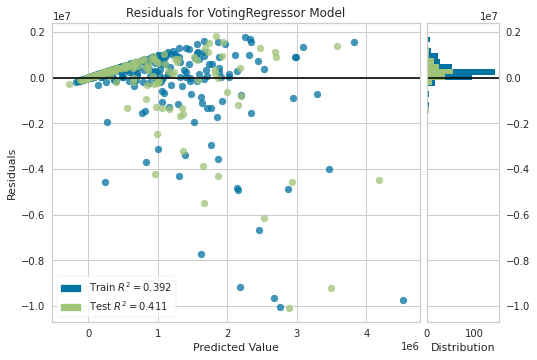

In [10]:
# 시각화
# 모델 시각화(plot)

plot_model(blender_specific)

In [11]:
y_train = df_train['box_off_num']

In [12]:
# 학습 및 예측
# 마지막 학습 및 예측(Finalize, Predict)

# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
prediction = predict_model(final_model, data=df_test)

In [13]:
prediction

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,Label
title,,,,,,,,,,,
용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,1.445455e+06
아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,1.249498e+06
하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,2.069527e+06
의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,1.779904e+06
평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,1.286240e+06
...,...,...,...,...,...,...,...,...,...,...,...
해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4,7.919853e+04
울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2,3.072027e+04
어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4,8.100926e+05


In [14]:
submission['box_off_num'] = prediction['Label']
submission.to_csv('automl_setup.csv')